In [9]:
# import libraries
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [19]:
historical_price = pd.read_csv('HistoricalPrices.csv')
historical_price.columns = ["Dates","Open","High","Low","Close"]
historical_price["Dates"] = pd.to_datetime(historical_price["Dates"])
international_indicies = pd.read_excel("International indices data.xlsx",skiprows=6)
international_indicies["Dates"] = pd.to_datetime(international_indicies["Dates"])

In [20]:
# merge the two dataframes on Dates
merged = pd.merge(historical_price, international_indicies, on="Dates", how="inner")

In [21]:
# Calculate the next 6-month return
merged["Six Month Return"] = (merged["Close"].shift(126)-merged["Close"])/merged["Close"]
merged.dropna(inplace=True)
merged.set_index("Dates", inplace=True)
merged = merged.sort_index(ascending=True)
merged



,Open,High,Low,Close,PX_LAST,PX_LAST.1,PX_LAST.2,PX_LAST.3,PX_LAST.4,PX_LAST.5,PX_LAST.6,PX_LAST.7,PX_LAST.8,PX_LAST.9,PX_LAST.10,PX_LAST.11,Six Month Return
Dates,,,,,,,,,,,,,,,,,
2005-10-21,5142.12,5164.00,5130.90,5142.12,1565.12,1179.59,2779.21,3271.05,87.48,1168.08,6840.0,7.157,6.7750,7.2668,7.1583,7.6601,0.186030
2005-10-24,5207.60,5210.10,5140.10,5207.60,1590.65,1199.38,2814.60,3310.13,86.79,1180.77,6885.0,7.109,6.7633,7.2576,7.1567,7.5785,0.168796
2005-10-25,5182.12,5222.40,5182.10,5182.12,1585.82,1196.54,2800.83,3292.52,86.98,1184.79,6915.0,7.140,6.7850,7.2163,7.1592,7.5754,0.177962
2005-10-26,5227.81,5236.50,5187.80,5227.81,1575.14,1191.38,2825.71,3304.27,87.01,1182.94,6970.0,7.102,6.7733,7.2441,7.1700,7.5723,0.159191
2005-10-27,5182.75,5224.40,5168.20,5182.75,1543.38,1178.90,2801.35,3241.14,86.30,1175.41,6980.0,7.087,6.7533,7.2483,7.1358,7.5661,0.162151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-15,7507.15,7508.58,7369.69,7389.64,15037.65,4437.86,7810.19,4288.57,168.89,2948.22,58726.0,7.205,7.6410,8.2810,7.6691,8.2671,0.016596
2023-08-16,7389.64,7398.20,7338.53,7356.88,14876.47,4404.33,7775.57,4284.27,167.39,2925.63,58606.0,7.205,7.6410,8.2810,7.6691,8.2671,0.028751
2023-08-17,7356.88,7356.96,7305.00,7310.21,14715.81,4370.36,7733.73,4227.83,167.73,2901.84,58294.0,7.249,7.7135,8.3535,7.7209,8.3189,0.039304


29/29 [==============================] - 1s 30ms/step
Mean Squared Error: 0.004646906732764689


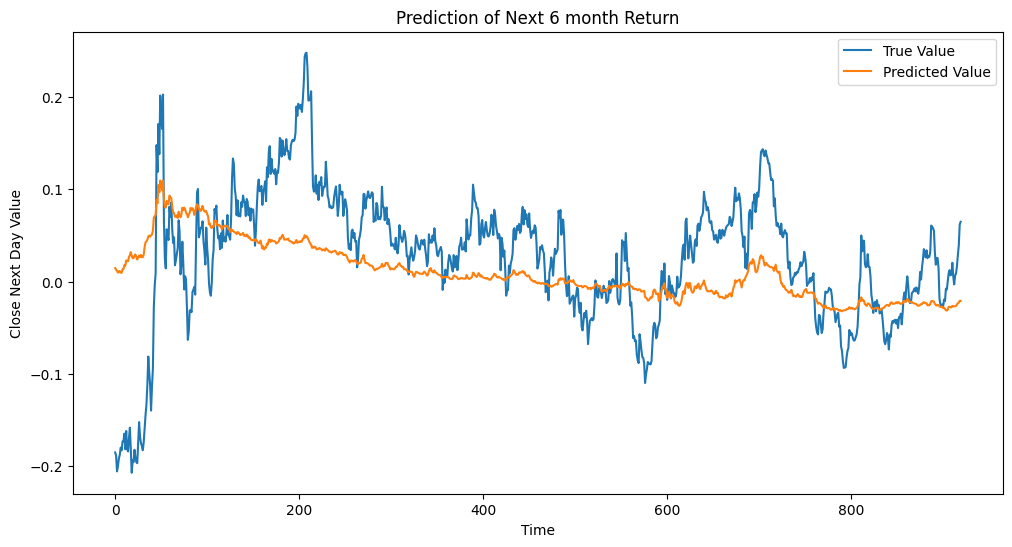

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Split the data into training and testing sets
train = merged.iloc[:int(0.8*len(merged))]
test = merged.iloc[int(0.8*len(merged)):]

# Scale the features
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(train.iloc[:, :-1])
X_test_scaled = feature_scaler.transform(test.iloc[:, :-1])

# Scale the target variable separately
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(train.iloc[:, -1].values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(test.iloc[:, -1].values.reshape(-1, 1))

# Reshape the data for LSTM input
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(500, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model.add(LSTM(500, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Fit the model
model.fit(X_train_scaled, y_train_scaled, batch_size=1, epochs=1)

# Make predictions
predictions_scaled = model.predict(X_test_scaled)
# Inverse transform the predictions to original scale
predictions = target_scaler.inverse_transform(predictions_scaled)

# Evaluate the model
mse = mean_squared_error(test.iloc[:, -1].values, predictions)
print(f'Mean Squared Error: {mse}')

# Plot the predictions against the true values
plt.figure(figsize=(12, 6))
plt.plot(test.iloc[:, -1].values, label="True Value")
plt.plot(predictions, label="Predicted Value")
plt.title("Prediction of Next 6 month Return")
plt.xlabel("Time")
plt.ylabel("Close Next Day Value")
plt.legend()
plt.show()


In [ ]:
# plot predictions individually
pred = pd.Series(predictions.flatten(), index=test.index)
pred.plot(label='Predictions')

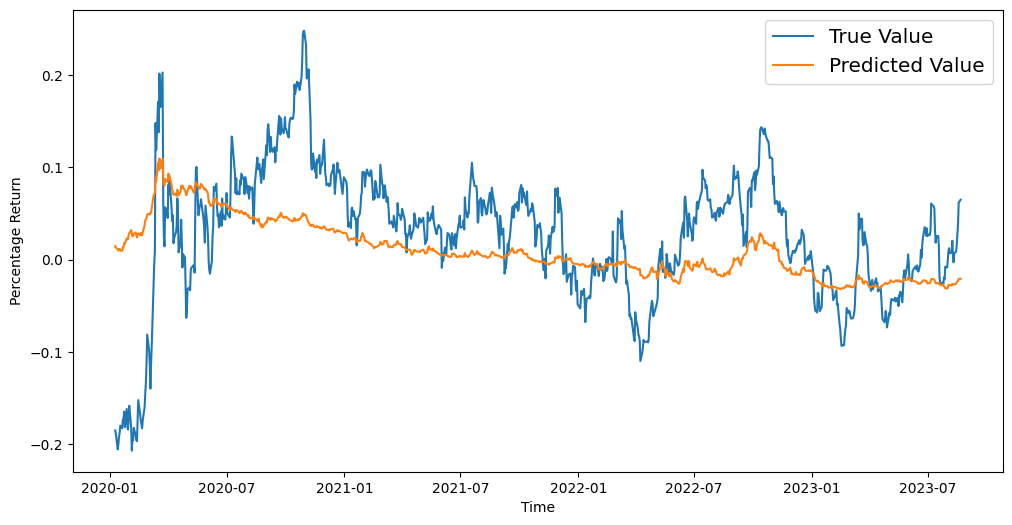

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.iloc[:, -1].values, label="True Value")
plt.plot(test.index, predictions, label="Predicted Value")
# plt.title("Prediction of Next 6 month Return")
plt.xlabel("Time")
plt.ylabel("Percentage Return")
plt.legend(fontsize='x-large') 
plt.show()

In [25]:
# Calculate the R^2
from sklearn.metrics import r2_score
r2 = r2_score(test.iloc[:, -1].values, predictions)
print(f'R^2: {r2}')

R^2: 0.09796015832618021
